#### Adopted User: a user who has logged into the product on three separate days in at least one seven­day period.

#### Goal: identify  which  factors  predict  future  user adoption.

In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_users = pd.read_csv('takehome_users.csv', encoding='latin1')
df_engagement = pd.read_csv('takehome_user_engagement.csv')

In [3]:
df_users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [4]:
#converting last_session_creation_time from int64 to datetime
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'], unit='s')

In [5]:
#checking last_session_creation_time
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [6]:
df_users.nunique()

object_id                     12000
creation_time                 11996
name                          11355
email                         11980
creation_source                   5
last_session_creation_time     8821
opted_in_to_mailing_list          2
enabled_for_marketing_drip        2
org_id                          417
invited_by_user_id             2564
dtype: int64

In [7]:
profile = ProfileReport(df_users, title="Users Data")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Important issues to address:
##### last_session_creation_time has 3177 (26.5%) missing values. 
##### invited_by_user_id has 5583 (46.5%) missing values.  This column will need to be dropped.

In [8]:
df_users = df_users.drop('invited_by_user_id', axis=1)

#### Other observation:
##### Medium strength positive correlation shown between enabled_for_marketing_drip and opted_in_to_mailing_list.

In [9]:
df_engagement.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [11]:
df_engagement['time_stamp'] = pd.to_datetime(df_engagement['time_stamp'])
df_engagement.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [12]:
# Finding and labeling adopted users.
df_engagement['adopted'] = df_engagement.groupby('user_id')['time_stamp'].apply(lambda x: ((x - x.shift()).dt.days >= 7).rolling(3).sum() >= 1).astype(int)
df_engagement.head()

/var/folders/j4/96_5xmgd7j362v_w7_09bvb40000gn/T/ipykernel_3922/1574209333.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_engagement['adopted'] = df_engagement.groupby('user_id')['time_stamp'].apply(lambda x: ((x - x.shift()).dt.days >= 7).rolling(3).sum() >= 1).astype(int)


,time_stamp,user_id,visited,adopted
0,2014-04-22 03:53:30,1,1,0
1,2013-11-15 03:45:04,2,1,0
2,2013-11-29 03:45:04,2,1,0
3,2013-12-09 03:45:04,2,1,1
4,2013-12-25 03:45:04,2,1,1


In [13]:
#dropping visited series, this column is full of 1's and doesn't assist the analysis.
df_adopted = df_engagement.copy()
df_adopted = df_adopted[['user_id','adopted']]
#dropping all rows that aren't an adopted instance.
df_adopted = df_adopted[df_adopted['adopted'] != 0]
#cleaning up the dataframe by keeping only 1 instance of each user_id
df_adopted = df_adopted.drop_duplicates('user_id', keep='first')
df_adopted.head()


,user_id,adopted
3,2,1
22,10,1
313,20,1
332,33,1
351,42,1


In [35]:
df_adopted.shape

(2200, 2)

In [14]:
#labeling all adopted records in merged_df
merged_df = pd.merge(df_users, df_adopted, left_on='object_id', right_on='user_id', how='left')
#Putting in 0 for all non-adopted records
merged_df['adopted'] = merged_df['adopted'].fillna(0)
#dropping user_id from merged_df
merged_df = merged_df.drop('user_id', axis=1)
merged_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,0.0


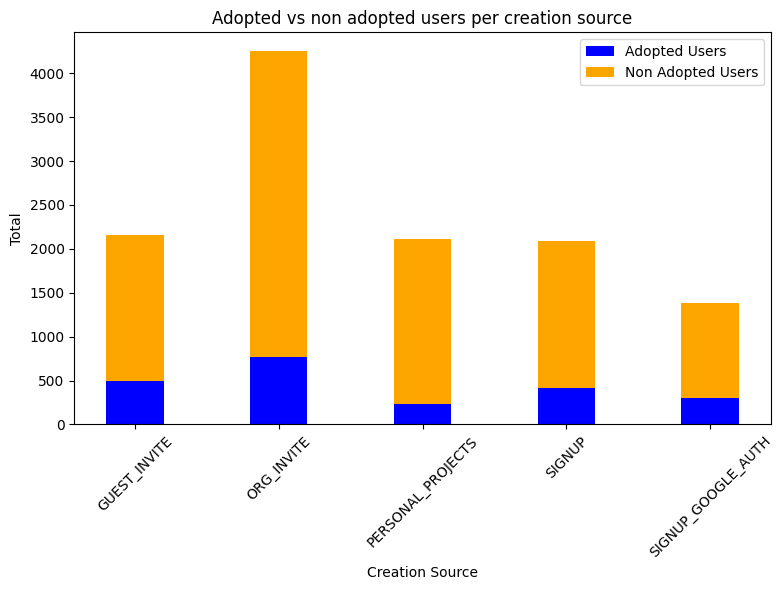

In [37]:
counts = merged_df[merged_df['adopted'] == 1].groupby('creation_source').size()
total_counts = merged_df.groupby('creation_source').size()
%matplotlib inline
fig, ax = plt.subplots()
bar_width = 0.4
positions = range(len(counts))
ax.bar(positions, counts, bar_width, label='Adopted Users', color='blue')
ax.bar(positions, total_counts - counts, bar_width, label='Non Adopted Users', color='orange',
       bottom=counts)
ax.set_xticks([p for p in positions])
ax.set_xticklabels(counts.index, rotation=45)
ax.set_xlabel('Creation Source')
ax.set_ylabel('Total')
ax.set_title('Adopted vs non adopted users per creation source')
ax.legend()
fig.set_size_inches(8, 6)
plt.tight_layout()
fig.savefig('graph.jpg', format='jpeg')
plt.show()

In [33]:
percentage = (counts / total_counts) * 100
result_df = pd.DataFrame({'Adoption Percentage': percentage,
                          'Total Counts': total_counts})
print(result_df)

                    Adoption Percentage  Total Counts
creation_source                                      
GUEST_INVITE                  22.699954          2163
ORG_INVITE                    18.006582          4254
PERSONAL_PROJECTS             10.800568          2111
SIGNUP                        19.645424          2087
SIGNUP_GOOGLE_AUTH            22.021661          1385


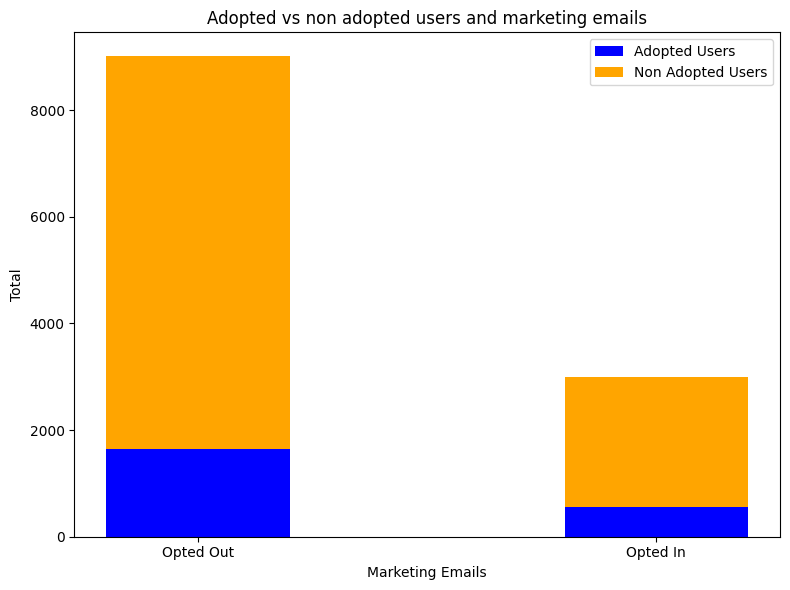

In [43]:
counts = merged_df[merged_df['adopted'] == 1].groupby('opted_in_to_mailing_list').size()
total_counts = merged_df.groupby('opted_in_to_mailing_list').size()
%matplotlib inline
fig, ax = plt.subplots()
bar_width = 0.4
positions = range(len(counts))
ax.bar(positions, counts, bar_width, label='Adopted Users', color='blue')
ax.bar(positions, total_counts - counts, bar_width, label='Non Adopted Users', color='orange',
       bottom=counts)
ax.set_xticks([0, 1])  # Set the positions of the ticks
ax.set_xticklabels(['Opted Out', 'Opted In'])
ax.set_xlabel('Marketing Emails')
ax.set_ylabel('Total')
ax.set_title('Adopted vs non adopted users and marketing emails')
ax.legend()
fig.set_size_inches(8, 6)
plt.tight_layout()
fig.savefig('graph2.jpg', format='jpeg')
plt.show()

In [44]:
percentage = (counts / total_counts) * 100
result_df2 = pd.DataFrame({'Adoption Percentage': percentage,
                          'Total Counts': total_counts})
print(result_df2)

                          Adoption Percentage  Total Counts
opted_in_to_mailing_list                                   
0                                   18.187875          9006
1                                   18.770875          2994


#### No significant change in adoption between the two groups.

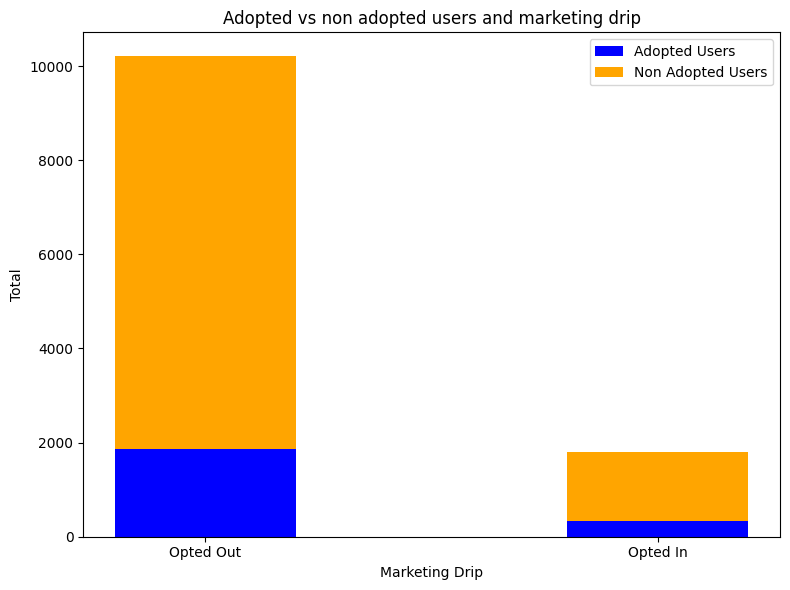

In [45]:
counts = merged_df[merged_df['adopted'] == 1].groupby('enabled_for_marketing_drip').size()
total_counts = merged_df.groupby('enabled_for_marketing_drip').size()
%matplotlib inline
fig, ax = plt.subplots()
bar_width = 0.4
positions = range(len(counts))
ax.bar(positions, counts, bar_width, label='Adopted Users', color='blue')
ax.bar(positions, total_counts - counts, bar_width, label='Non Adopted Users', color='orange',
       bottom=counts)
ax.set_xticks([0, 1])  # Set the positions of the ticks
ax.set_xticklabels(['Opted Out', 'Opted In'])
ax.set_xlabel('Marketing Drip')
ax.set_ylabel('Total')
ax.set_title('Adopted vs non adopted users and marketing drip')
ax.legend()
fig.set_size_inches(8, 6)
plt.tight_layout()
fig.savefig('graph2.jpg', format='jpeg')
plt.show()

In [46]:
percentage = (counts / total_counts) * 100
result_df3 = pd.DataFrame({'Adoption Percentage': percentage,
                          'Total Counts': total_counts})
print(result_df3)

                            Adoption Percentage  Total Counts
enabled_for_marketing_drip                                   
0                                     18.250392         10208
1                                     18.805804          1792


#### No significant change in adoption between the two groups.